## Simple CNN network

The original problem is:

    (P) Compute the fabrics from multiple sliced images per rev

We are firstly having an intermediate objective:

    (P') Compute the fabrics from one single sliced images per rev

Of course, the accuracy will be much worse because the fabrics are computed in every direction. However, it is a good try.

# Importing the dataframe

Firstly, we initialize wandb. It is a tool that allows to store the losses and retrieve the deframe. Otherwise, you can directly access locally the dataframe on your computer.

In [26]:
!pip install wandb --upgrade

We import all the useful packages.

In [2]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

import wandb
from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

log_wandb = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


[INFO]: Computation device: cpu


We initialize a wandb run, that will save our metrics

In [3]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="microstructure-reconstruction",
        group="Naive Network",
        job_type="test",
    )


Parameters of our run:

In [7]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_split"] = 0.7
config["seed"] = 42
config["batch_size"] = 64
config["learning_rate"] = 0.00005
config["device"] = device
config["momentum"] = 0.9
config["architecture"] = "VGG"
config["input_width"] = 64
config["weight_decay"] = 0.00
config["epochs"] = 0
config["frac_sample"] = 1
# config["total_layers"] = 24
# config["fixed_layers"] = 0
config["log_wandb"] = log_wandb
torch.manual_seed(config["seed"])
pl.seed_everything(config["seed"])


Global seed set to 42


42

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        repo_path,
        train_df=None,
        test_df=None,
    ):
        super().__init__()
        self.config = config
        self.repo_path = repo_path
        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None

        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/train_df:1_images"
                )
            if self.test_df is None:
                self.test_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/test_df:1_images"
                )

        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(207),
                transforms.Resize(
                    (self.config["input_width"], self.config["input_width"])
                ),
                transforms.ToTensor(),
                transforms.GaussianBlur(kernel_size=3, sigma=0.5),
            ]
        )

    def prepare_data(self):
        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at.download()
            if self.test_df is None:
                self.test_data_at.download()

    def _init_df_wandb(self):
        if self.train_df is None:
            self.train_df = wandb_api.convert_table_to_dataframe(
                self.training_data_at.get("fabrics")
            )
            self.train_df["photos"] = self.train_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )
        if self.test_df is None:
            self.test_df = wandb_api.convert_table_to_dataframe(
                self.test_data_at.get("fabrics")
            )
            self.test_df["photos"] = self.test_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )

    def _init_df_local(self):
        fabrics_df = pd.read_csv(self.repo_path / "REV1_600/fabrics.txt")
        path_to_slices = self.repo_path / "REV1_600/REV1_600Slices"
        fabrics_df["photos"] = fabrics_df["id"].apply(
            func=dataframe_reformat.associate_rev_id_to_its_images,
            args=(path_to_slices, 10),
        )
        fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
        fabrics_df["photos"] = fabrics_df["photos"].apply(func=lambda x: sorted(x))
        train_df, test_df = train_test_split(
            fabrics_df,
            train_size=config["train_val_split"],
            random_state=config["seed"],
            shuffle=True,
        )
        if self.train_df is None:
            self.train_df = train_df.reset_index(drop=True)
        if self.test_df is None:
            self.test_df = test_df.reset_index(drop=True)

    def init_df(self):
        if self.config["log_wandb"]:
            self._init_df_wandb()
        else:
            self._init_df_local()

    def setup(self, stage):
        self.init_df()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit_transform(self.train_df.iloc[:, 1:-1])
        self.scaler.transform(self.test_df.iloc[:, 1:-1])
        normalized_train_df = deepcopy(self.train_df)
        normalized_train_df.iloc[:, 1:-1] = self.scaler.transform(
            self.train_df.iloc[:, 1:-1]
        )
        normalized_test_df = deepcopy(self.test_df)
        normalized_test_df.iloc[:, 1:-1] = self.scaler.transform(
            self.test_df.iloc[:, 1:-1]
        )
        self.kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(
            normalized_train_df.iloc[:, 1:-1].to_numpy()
        )

        self.train_dataset = dataset.SinglePhotoDataset(
            normalized_train_df, transform=self.transform
        )
        self.validation_dataset = dataset.SinglePhotoDataset(
            normalized_test_df, transform=self.transform
        )
        self.targets = self.test_df.iloc[:, 1:-1].to_numpy()

        

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config["batch_size"],
            shuffle=True,
            **kwargs,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            [image for image, _ in self.validation_dataset],
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )


dm = DataModule(config, repo_path)


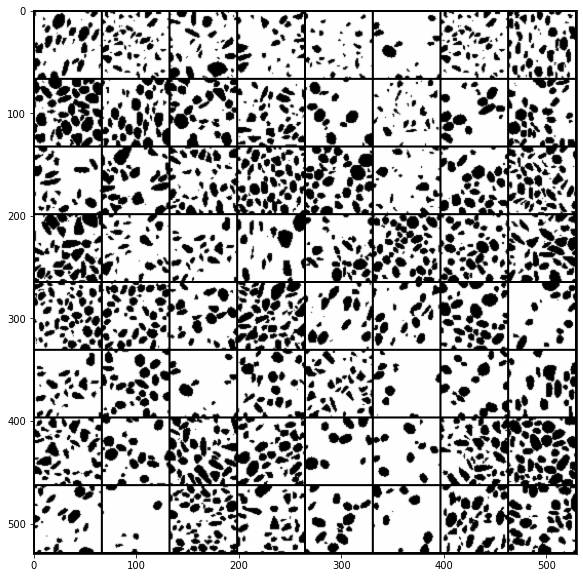

In [9]:
dm.prepare_data()
dm.setup(stage="fit")
first_batch = next(iter(dm.train_dataloader()))

images, labels = first_batch[0], first_batch[1]
grid = utils.make_grid(images)
fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [36]:
class VGG11(models.BaseModel):
    def __init__(self, config, kde = None, scaler=None):
        super().__init__(config)

        self.config = config
        self.config["model_type"] = type(self)
        self.kde = kde
        self.scaler = scaler

        self.configure_model()
        self.configure_criterion()
        self.configure_metrics()

    def configure_model(self):
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #             nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #             nn.ReLU(),
            #             nn.Conv2d(128, 128, kernel_size=3, padding=1),
            #             nn.ReLU(),
            #             nn.MaxPool2d(kernel_size=2, stride=2),
            #             nn.Conv2d(64, 64, kernel_size=3, padding=1),
            #             nn.ReLU(),
            #             nn.Conv2d(64, 64, kernel_size=3, padding=1),
            #             nn.BatchNorm2d(64),
            #             nn.ReLU(),
            #             nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(
                kernel_size=self.config["input_width"] // (2 ** 3),
                stride=self.config["input_width"] // (2 ** 3),
            ),
        )
        input_fc = int((self.config["input_width"] / (2 ** 5)) ** 2 * 64)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64, out_features=(256)),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=256, out_features=23),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        weights = self.kde.score_samples(y_hat.detach().numpy())
        loss = self.criterion(y_hat, y, 1/torch.FloatTensor(weights))
        self.log(
            "train_loss",
            loss,
            on_step=False,
            on_epoch=True,
        )
        return loss

    def configure_criterion(self):
        self.criterion = self.L1Loss
        self.config["loss_type"] = type(self.criterion)

    def L1Loss(self, y, y_hat, weights=None):
        if weights is not None:
            return torch.mean(torch.matmul(weights, torch.abs(y - y_hat)))
        else: 
            return torch.mean(torch.abs(y - y_hat))

    def configure_metrics(self):
        self.metrics = {
            "val_loss": self.criterion,
            "mae": torchmetrics.MeanAbsoluteError().to(self.config["device"]),
            "mape": torchmetrics.MeanAbsolutePercentageError().to(
                self.config["device"]
            ),
            "smape": torchmetrics.SymmetricMeanAbsolutePercentageError().to(
                self.config["device"]
            ),
            "r2_score": torchmetrics.R2Score(num_outputs=23).to(self.config["device"]),
            "cosine_similarity": torchmetrics.CosineSimilarity(reduction="mean").to(
                self.config["device"]
            ),
        }


model = VGG11(config, kde=dm.kde)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
model(torch.rand((1, 1, config["input_width"], config["input_width"])))


[INFO]: 148,695 total parameters.


tensor([[ 0.1291,  0.6119, -0.2372, -1.0504,  0.6983,  0.2777,  0.3527, -0.3135,
          0.6641, -0.3022,  0.6098,  0.6631,  0.0850, -0.2911, -0.7254,  0.9624,
          0.3979, -0.2871,  0.0807, -0.7169,  0.1778,  0.8250, -0.1092]],
       grad_fn=<AddmmBackward0>)

In [34]:
model_checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=run.dir,
    filename="{epoch}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_last=True,
)

script_checkpoint = training.ScriptCheckpoint(
    dirpath=run.dir,
)

callbacks = [script_checkpoint]
log = None
if run.job_type == "train" or True:
    callbacks.append(model_checkpoint)
    print(f"[INFO]: saving models.")
if run.job_type == "debug":
    log = "all"


[INFO]: saving models.


In [37]:
if config["log_wandb"]:
    pass
    # wandb_logger = pl.loggers.WandbLogger()
    # wandb_logger.watch(model, log=log, log_graph=True)
else:
    wandb_logger = None
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=callbacks,
    logger=wandb_logger,
    devices="auto",
    accelerator="auto",
    limit_train_batches=0.1,
    limit_val_batches=0.2,
    log_every_n_steps=1
)
trainer.fit(
    model,
    datamodule=dm,
)


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type       | Params
---------------------------------------------
0 | conv_layers   | Sequential | 60.4 K
1 | linear_layers | Sequential | 88.3 K
---------------------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.595     Total estimated model params size (MB)
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1: val_loss reached 0.50979 (best 0.50979), saving model to "/home/matias/microstructure-reconstruction/wandb/run-20220228_103303-2ggqop4e/files/epoch=0-val_loss=0.510.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 5: val_loss was not in top 1
Saving latest checkpoint...


In [ ]:
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.FloatTensor(dm.targets)


In [ ]:
print(predictions.shape, targets.shape)


In [ ]:
save_output = training.SaveOutput()
handle = model.conv_layers[3].register_forward_hook(save_output)
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:30]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


In [ ]:
fig = plotting.plot_hist(
    targets.cpu().numpy(),
    predictions.cpu().numpy(),
    nb_hist_per_line=6,
    columns=dm.train_df.columns[1:-1],
)
